In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import dlib
import time
import random
import imutils
from imutils import face_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set the paths for training and testing data
train_data_dir = 'Latest Dataset/Train'
test_data_dir = 'Latest Dataset/Test'
CATEGORIES = ["Anger", "Joy", "Natural", "Sadness"]
IMG_SIZE = 128

# Define image size and batch size
img_size = (128, 128)
batch_size = 16

In [2]:
# Initialize the Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [3]:
# Load pre-trained dlib model for feature extraction
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
data = {} # Make dictionary for all values

In [4]:
import math
def extract_landmarks(faces, gray, resize_dims=(128, 128)):
    if len(faces) < 1: #if no landmarks were detected, store error in dictionary 
        data['landmarks_vestorised'] = "error"
    
    # Assume one face per image
    for (i, rect) in enumerate(faces):
        shape = predictor(gray, rect)
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        #record mean values of both X Y coordinates    
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        #store central deviance 
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):    #analysing presence of facial landmarks 
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            #extract center of gravity with mean of axis
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            #measuring distance and angle of each landmark from center of gravity 
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            # Computes the arctangent of the quotient y/x and converts from radian to degrees
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        #store landmarks in global dictionary
        data['landmarks_vectorised'] = landmarks_vectorised 

**Testing**

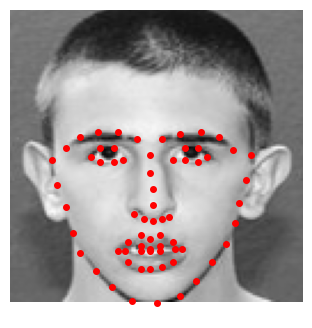

In [5]:
# Example image path
example_image_path = ("Latest Dataset/Train/anger/1248.jpg")
img = cv2.imread(example_image_path)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(imgray, img_size)
img_normalized = cv2.equalizeHist(img_resized)

# Detect faces in the grayscale image
faces = detector(img_normalized, 1)

# Extract landmarks and image
# Assume one face per image
for (i, rect) in enumerate(faces):
    shape = predictor(img_normalized, rect)
    shape_np = face_utils.shape_to_np(shape)

if shape is not None:
    # Convert image to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.figure(figsize=(4,4))
    plt.imshow(image_rgb)
    plt.axis('off')

    # Overlay the landmarks
    for (x, y) in shape_np:
        plt.plot(x, y, 'ro', markersize=4)

    plt.show()
else:
    print("No faces detected.")


**Preprocess Image Data**

In [6]:
images = []
gray_image = []

for label, class_name in enumerate(CATEGORIES):
    class_dir = os.path.join(train_data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        faces = detector(gray, 1)
        images.append([faces, gray, label])
        # labels.append(label)

## Feature Extraction - Facial Landmarks

**Computational Performance Metrics (Time)**

In [7]:
features = []
labels = []
start_time = time.time()

for (faces, gray, label) in images:
    extract_landmarks(faces, gray)
    if data['landmarks_vectorised'] == "error":
        print("no face detected on this one")
    else:
        features.append(data['landmarks_vectorised'])
        labels.append(label)

end_time = time.time()
execution_time = end_time - start_time
print(f'Feature extraction time: {execution_time} seconds')

Feature extraction time: 0.7270383834838867 seconds


In [8]:
# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Save the features and labels to disk or use them directly in a model
np.save('features.npy', features)
np.save('labels.npy', labels)

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
X_train.shape

(625, 268)

In [11]:
y_train.shape

(625,)

## Fit to Neural Network

In [12]:
# One-hot encode labels
num_classes = len(CATEGORIES)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
input_shape = X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr], shuffle=True)

Epoch 1/50


d:\FYP Face Recognition\virtual_env\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2605 - loss: 8.0392 - val_accuracy: 0.1911 - val_loss: 8.0039 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3193 - loss: 7.8246 - val_accuracy: 0.3758 - val_loss: 7.4199 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3276 - loss: 7.6877 - val_accuracy: 0.4395 - val_loss: 7.1246 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3391 - loss: 7.3257 - val_accuracy: 0.4013 - val_loss: 6.9180 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4025 - loss: 7.1235 - val_accuracy: 0.4459 - val_loss: 6.6691 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3918 - loss: 6.9179 - val_accuracy: 0.4650 - val_loss: 6.4571 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4095 - loss: 6.6624 - val_accuracy: 0.4586 - v

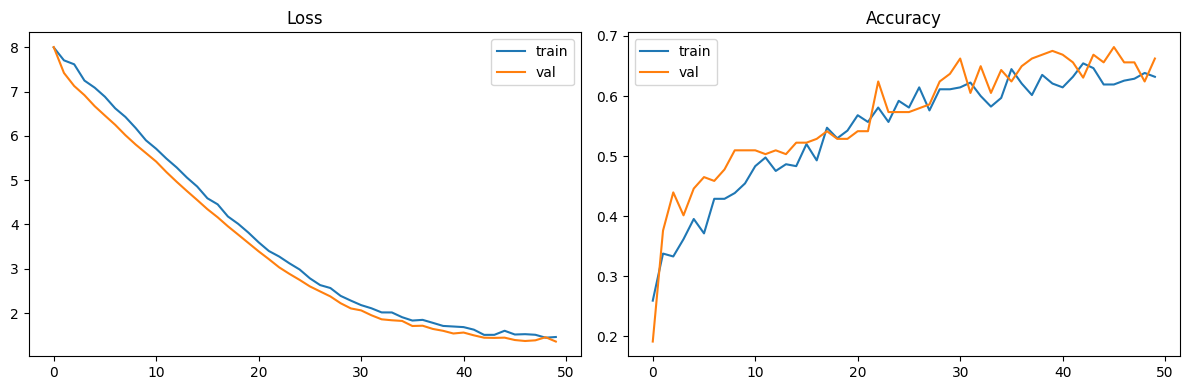

In [15]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 66.24%
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        24
         Joy       0.76      0.96      0.84        68
     Natural       0.41      0.50      0.45        18
     Sadness       0.61      0.64      0.62        47

    accuracy                           0.66       157
   macro avg       0.44      0.52      0.48       157
weighted avg       0.56      0.66      0.60       157



d:\FYP Face Recognition\virtual_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\FYP Face Recognition\virtual_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\FYP Face Recognition\virtual_env\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


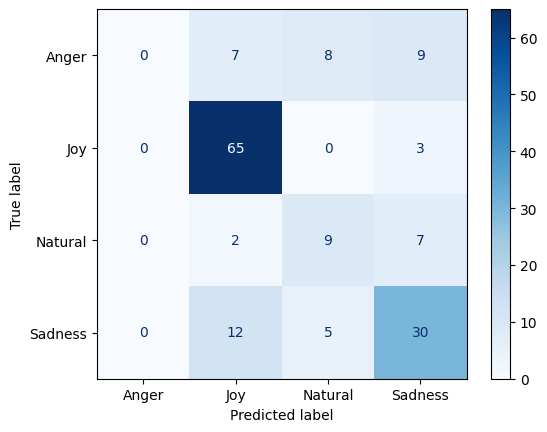

In [16]:
# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()